In [1]:
Threads.nthreads()

16

In [2]:
using Distributions
using Random
using LinearAlgebra
using Plots
using StatsBase
using LaTeXStrings
using ProgressBars
using ProgressMeter
using DataFrames
using CSV
using Base.Threads
gr()

Plots.GRBackend()

In [16]:
function ini()
    # Hund's Rule Ground J-Multiplet Ce3+ n4f=1
    n4f = 1
    L = 3
    S = 1 / 2
    J = L - S
    g = 1 + (J * (J + 1) + S * (S + 1) - L * (L + 1)) / (2 * J * (J + 1))
    Jz = [5 / 2, 3 / 2, 1 / 2, -1 / 2, -3 / 2, -5 / 2]
    return J, g, Jz
end
J, g, Jz = ini()

function para()
    n = 350 # temp length
    Temp_table = collect(0.2:0.2:70) # length 496
    noise = 4
    return n, Temp_table, noise
end
n, Temp_table, noise = para()

(496, [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4  …  49.1, 49.2, 49.3, 49.4, 49.5, 49.6, 49.7, 49.8, 49.9, 50.0], 4)

In [17]:
function Onn_make(B40)
    #B40 = 0.1167
    B44 = 5 * B40

# O40
    O40_vec = (35 * Jz.^4 - 30 * J * (J + 1) * Jz.^2 + 25 * Jz.^2 .- 6 * J * (J + 1) .+ 3 * J^2 * (J + 1)^2) * B40
    O40 = diagm(0 => O40_vec)

# O44
    O44 = zeros(6, 6)

    Jz_vec_1 = Jz[1] .- collect(0:3)
    O44[5,1] = sqrt(prod(J .+ Jz_vec_1) * prod((J + 1) .- Jz_vec_1)) * B44 / 2

    Jz_vec_2 = Jz[2] .- collect(0:3)
    O44[6,2] = sqrt(prod(J .+ Jz_vec_2) * prod((J + 1) .- Jz_vec_2)) * B44 / 2

    Jz_vec_5 = Jz[5] .+ collect(0:3)
    O44[1,5] = sqrt(prod(J .- Jz_vec_5) * prod((J + 1) .+ Jz_vec_5)) * B44 / 2

    Jz_vec_6 = Jz[6] .+ collect(0:3)
    O44[2,6] = sqrt(prod(J .- Jz_vec_6) * prod((J + 1) .+ Jz_vec_6)) * B44 / 2

    Onn = O40 + O44

    return Onn
end

Onn_make (generic function with 1 method)

In [18]:
#check
Onn_make(0.1167)

6×6 Matrix{Float64}:
  7.002     0.0      0.0     0.0     15.6569   0.0
  0.0     -21.006    0.0     0.0      0.0     15.6569
  0.0       0.0     14.004   0.0      0.0      0.0
  0.0       0.0      0.0    14.004    0.0      0.0
 15.6569    0.0      0.0     0.0    -21.006    0.0
  0.0      15.6569   0.0     0.0      0.0      7.002

In [19]:
# 磁化率
function chi(Onn)
    magfield = 0.01
    magdir = [0,0,1]
    nor_magdir = magdir / sqrt(sum(magdir.^2))

# 対角要素
    Hmag_vec_0 = Jz * nor_magdir[3] * magfield * g * 0.67171
    Hmag = diagm(0 => Hmag_vec_0)

# 非対角要素はmagdir[x,y]が0なので0

# 結晶場＋磁場ハミルトニアンの行列要素
    H = Onn + Hmag

    eigval, eigvec = eigen(H)

    chi_inv_Temp = zeros(n)
    for (i, Temp) in enumerate(Temp_table)
        eigval_2 = - eigval / Temp
        eigval_2_max = maximum(eigval_2)
        eigval_ratio = eigval_2 .- eigval_2_max
        exp_eigval = exp.(eigval_ratio)
        sumexp = sum(exp_eigval)

        mag_z = zeros(6)
        for i in 1:6
            eigvec_check = eigvec[:,i]
            mag_z[i] = eigvec_check' * (eigvec_check .* Jz) * exp_eigval[i] / sumexp
        end

        Jmag_z = sum(mag_z) * g * (-1)
        Jmag = Jmag_z

        chi = Jmag / magfield * 0.5585
        chi_inv = 1 / chi
        chi_inv_Temp[i] = chi_inv
    end
    return chi_inv_Temp
end

chi (generic function with 1 method)

In [20]:
chi_inv_Temp = chi(Onn_make(0.1167))
chi_inv_Temp_noise = chi_inv_Temp + rand([-1,1]) * noise * randn(n);

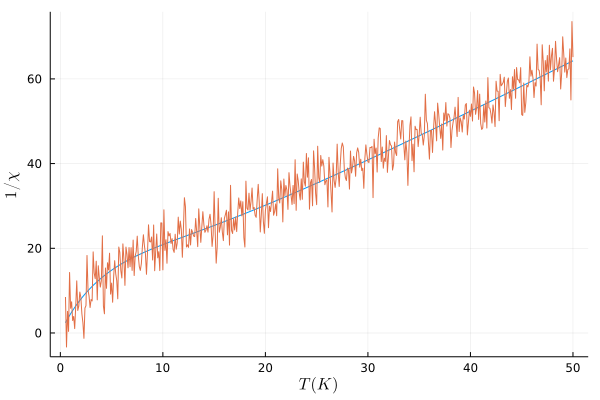

In [57]:
plot(Temp_table,chi_inv_Temp)
plot!(Temp_table,chi_inv_Temp_noise)
plot!(xlabel=L"T(K)",ylabel=L"1/\chi",legend=false)

In [197]:
function para1()
    L = 26 # レプリカ数
    gamma = 1.1
    C = 0.1
    d = 1.1
    return L, gamma, C, d
end
L, gamma, C, d = para1()

function para2()
    xi = 2
    nu = 0
    return xi,nu
end
xi,nu = para2()

(2, 0)

In [198]:
function beta_list()
    beta = zeros(L)
    for i in 2:L
        beta[i] = gamma^(i - L)
    end
    return beta
end
beta = beta_list()

26-element Vector{Float64}:
 0.0
 0.10152559799477044
 0.11167815779424749
 0.12284597357367225
 0.13513057093103947
 0.14864362802414344
 0.16350799082655781
 0.1798587899092136
 0.19784466890013497
 0.2176291357901485
 0.23939204936916336
 0.26333125430607973
 0.28966437973668774
 0.3186308177103565
 0.3504938994813922
 0.3855432894295314
 0.4240976183724846
 0.4665073802097331
 0.5131581182307065
 0.5644739300537771
 0.6209213230591549
 0.6830134553650705
 0.7513148009015775
 0.8264462809917354
 0.9090909090909091
 1.0

In [199]:
function step_list()
    step = ones(L) * C
    for i in 1:L
        if n * beta[i] > 1
            step[i] = C / (n * beta[i])^d
        end
    end
    return step
end
step_size = step_list()

26-element Vector{Float64}:
 0.1
 0.0013419521919343213
 0.001208384345411978
 0.0010881108395761688
 0.0009798084555617903
 0.000882285677775548
 0.0007944695851410394
 0.0007153940470908868
 0.0006441890944411949
 0.0005800713482093677
 0.0005223354010755449
 0.0004703460566686618
 0.00042353134129571364
 0.0003813762112310229
 0.0003434168863346922
 0.00030923574766013486
 0.00027845674291544683
 0.0002507412492306596
 0.00022578434771408117
 0.00020331146881132978
 0.00018307537156014468
 0.00016485342350749515
 0.00014844515136331907
 0.00013367003544380033
 0.00012036552363920428
 0.00010838524305644445

In [200]:
function prior_list(B40_list)
    prior_40_list = sqrt(xi / 2 * pi) * exp.(- xi * (B40_list .- nu).^2 / 2)
    return prior_40_list
end

prior_list (generic function with 2 methods)

In [201]:
function error(B40)
    error_value = sum((chi_inv_Temp_noise - chi(Onn_make(B40))).^2)/(2*n)
    return error_value
end

error (generic function with 2 methods)

In [202]:
function error_list(B40_list)
    error_ls = zeros(L)
    @threads for i in 1:L
        error_value = error(B40_list[i])
        error_ls[i] = error_value
    end
    return error_ls
end


error_list (generic function with 2 methods)

In [203]:
# metropolis
function metropolis(B40_list, saitaku)
    B40_proposed = B40_list + rand([-1,1],L) .* step_size
    
    prior_ratio = prior_list(B40_proposed) ./ prior_list(B40_list)
    error_dif = error_list(B40_proposed) - error_list(B40_list)
    
    bit_vec = rand(L) .< exp.(- n / noise * beta .* error_dif) .* prior_ratio
    for i in 1:L
        if bit_vec[i] == 0 # 交換しない
            B40_proposed[i] = B40_list[i]
        else #交換
            saitaku[i] += 1
        end
    end
    return B40_proposed, saitaku
end

metropolis (generic function with 2 methods)

In [204]:
# metropolis(採択率不要ver)
function metropolis_2(B40_list)
    B40_proposed = B40_list + rand([-1,1],L) .* step_size
    
    prior_ratio = prior_list(B40_proposed) ./ prior_list(B40_list)
    error_dif = error_list(B40_proposed) - error_list(B40_list)
    
    bit_vec = rand(L) .< exp.(- n / noise * beta .* error_dif) .* prior_ratio
    for i in 1:L
        if bit_vec[i] == 0 # 交換しない
            B40_proposed[i] = B40_list[i]
        end
    end
    return B40_proposed
end

metropolis_2 (generic function with 1 method)

In [205]:
# exchange
function exchange(B40_list, koukann, koukann_total)
    #レプリカからランダムに選択
    l = rand(collect(1:L-1))
    
    beta_dif = beta[l + 1] - beta[l]
    error_dif = error(B40_list[l + 1]) - error(B40_list[l])
    v = exp(n / noise * beta_dif * error_dif)
    u = minimum([1,v])
    items = [1,0]
    weights = [u,1 - u]
    item = sample(items, Weights(weights)) # 1で交換
    
    #交換
    if item == 1
        B40_list[l + 1], B40_list[l] = B40_list[l], B40_list[l + 1]
        koukann[l] += 1
    end
    
    #レプリカ選択の記録
    koukann_total[l] += 1
    return　B40_list, koukann, koukann_total
end


exchange (generic function with 2 methods)

In [206]:
# exchange(交換率不要ver)
function exchange_2(B40_list)
    #レプリカからランダムに選択
    l = rand(collect(1:L-1))
    
    beta_dif = beta[l + 1] - beta[l]
    error_dif = error(B40_list[l + 1]) - error(B40_list[l])
    v = exp(n / noise * beta_dif * error_dif)
    u = minimum([1,v])
    items = [1,0]
    weights = [u,1 - u]
    item = sample(items, Weights(weights)) # 1で交換
    
    if item == 1
        B40_list[l + 1], B40_list[l] = B40_list[l], B40_list[l + 1]
    end

    return　B40_list
end

exchange_2 (generic function with 1 method)

In [235]:
B40_test = collect(-0.5:0.0001:0.5)
error_test_list = zeros(length(B40_test))
@threads for i in 1:(length(B40_test))
    error_test_list[i] = error(B40_test[i])
end

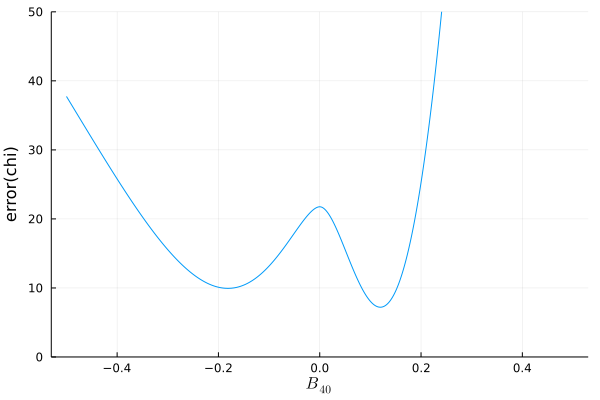

In [236]:
plot(B40_test,error_test_list,ylims=(0,50))
plot!(xlabel=L"B_{40}",ylabel="error(chi)")
plot!(legend=false)

In [237]:
answer_1 = B40_test[argmin(error_test_list)]
println("大域解:",answer_1)
error_test_list_2 = error_test_list[1:Int64(floor(length(B40_test)/2))]
answer_2 = B40_test[argmin(error_test_list_2)]
println("局所解:",answer_2)

大域解:0.1196
局所解:-0.1812


In [209]:
# exmc
function emc(size_simu, burn_in, frequency_exchange)
    # 初期パラメータ値
    B40_list = nu .+ rand([-1,1],L) .* randn(L) / sqrt(xi)
    
    #格納用(beta=1の値を保存)
    B40_keep = zeros(size_simu-burn_in)
    
    #採択率,交換率記録
    saitaku = zeros(L)
    koukann = zeros(L)
    koukann_total = zeros(L)
    
    # 更新
    p = Progress(burn_in; showspeed=true)
    q = Progress(size_simu-burn_in; showspeed=true)
    
    #バーンイン区間
    for iter in 1:burn_in
        B40_list = metropolis_2(B40_list)
        
        if iter % frequency_exchange == 0
            B40_list = exchange_2(B40_list)
        end
        
        ProgressMeter.next!(p)
    end
    
    #バーンイン終了後
    for iter in 1:size_simu-burn_in
        B40_list, saitaku = metropolis(B40_list, saitaku)
        
        if iter % frequency_exchange == 0
            B40_list, koukann = exchange(B40_list, koukann,koukann_total)
        end
        
        B40_keep[iter] = B40_list[end]
        ProgressMeter.next!(q)
    end
    
    
    saitaku = saitaku / size_simu
    koukann = koukann ./ koukann_total
    
    return B40_keep,saitaku,koukann
end

emc (generic function with 1 method)

In [214]:
B40_list,saitaku,koukann = emc(50000, 25000, 2)

Progress: 100%|███████████████████████████| Time: 0:23:44 (56.98 ms/it)
Progress: 100%|███████████████████████████| Time: 0:47:38 ( 0.11  s/it)mt)m


([0.11653438385107792, 0.11664276909413436, 0.11653438385107792, 0.11664276909413436, 0.11653438385107792, 0.12048873123690902, 0.12059711647996546, 0.12048873123690902, 0.12038034599385258, 0.12027196075079614  …  0.11781875779420131, 0.11771037255114487, 0.11781875779420131, 0.11792714303725775, 0.11803552828031419, 0.11803552828031419, 0.11814391352337063, 0.11825229876642707, 0.11814391352337063, 0.11814391352337063], [0.47042, 0.43222, 0.4394, 0.44102, 0.44776, 0.44724, 0.45166, 0.45356, 0.45706, 0.458  …  0.47186, 0.47506, 0.47624, 0.47728, 0.47896, 0.47896, 0.47916, 0.4814, 0.482, 0.48364], [0.022058823529411766, 0.9769392033542977, 0.9779005524861878, 0.9650924024640657, 0.9678111587982833, 0.9766949152542372, 0.9522900763358778, 0.9704142011834319, 0.9596774193548387, 0.974  …  0.9530956848030019, 0.9686888454011742, 0.9695652173913043, 0.9782178217821782, 0.9812108559498957, 0.9760479041916168, 0.9654471544715447, 0.9710743801652892, 0.9587426326129665, NaN])

In [215]:
B40_list;

In [216]:
df = DataFrame(
           beta_list=beta,
           採択率_B40=saitaku,
           交換率=koukann)

,beta_list,採択率_B40,交換率
,Float64,Float64,Float64
1,0.0,0.47042,0.0220588
2,0.101526,0.43222,0.976939
3,0.111678,0.4394,0.977901
4,0.122846,0.44102,0.965092
5,0.135131,0.44776,0.967811
6,0.148644,0.44724,0.976695
7,0.163508,0.45166,0.95229
8,0.179859,0.45356,0.970414
9,0.197845,0.45706,0.959677


交換率小さい

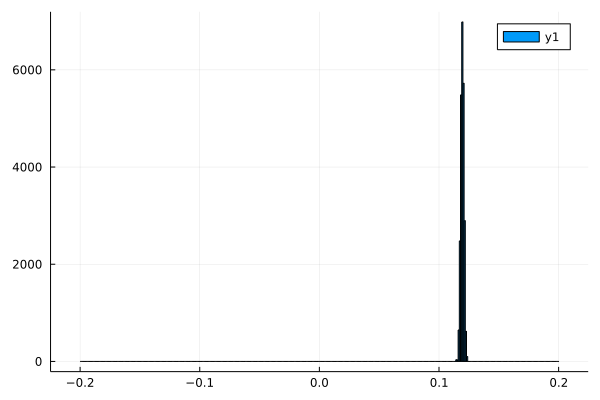

In [239]:
histogram(B40_list; bin=range(-0.2, 0.2, step=0.001))

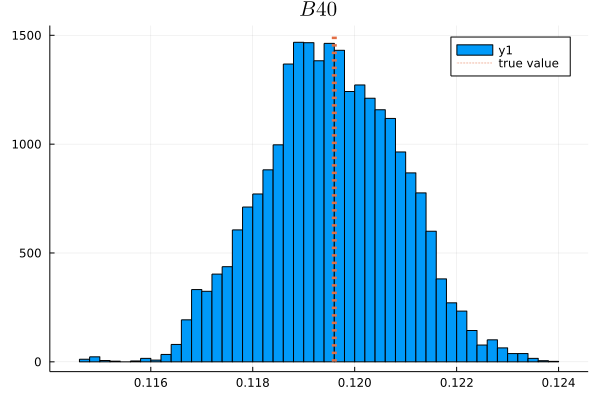

In [240]:
plot(B40_list,st=:histogram)
plot!(title=L"B40")
plot!(answer_1*ones(1500),collect(1:1500), linestyle=:dot,linewidth = 5,label="true value")

In [241]:
function error_min_find(B40_list)
    error_list = zeros(length(B40_list))
    @threads for i in 1:length(B40_list)
        error_list[i] = error(B40_list[i])
    end
    estimate_para = B40_list[argmin(error_list)]
    return estimate_para
end

error_min_find (generic function with 1 method)

In [243]:
estimate_para = error_min_find(B40_list)

0.11963850144641086

In [248]:
println("estimate parameter:",estimate_para)
println("true value:",answer_1)

estimate parameter:0.11963850144641086
true value:0.1196


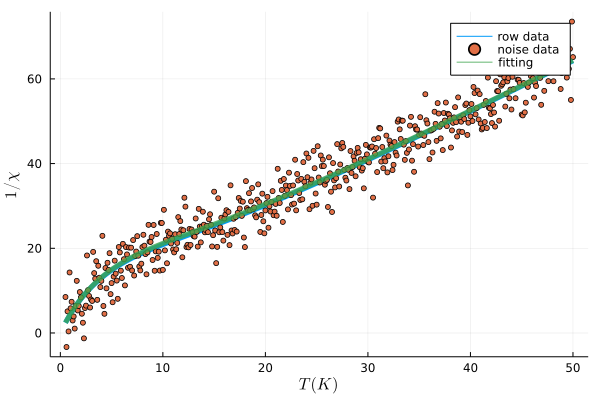

In [246]:
plot(Temp_table,chi_inv_Temp, linewidth = 5, label = "row data")
plot!(Temp_table,chi_inv_Temp_noise,st = :scatter,markersize = 3, label = "noise data")
plot!(Temp_table,chi(Onn_make(estimate_para)),linewidth = 5, alpha = 0.8, label = "fitting")
plot!(xlabel=L"T(K)",ylabel=L"1/\chi")

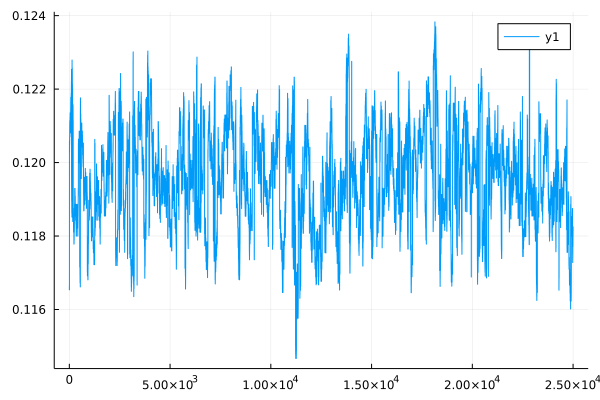

In [249]:
plot(B40_list)

In [251]:
df2 = DataFrame(
           B40=B40_list
)

,B40
,Float64
1,0.116534
2,0.116643
3,0.116534
4,0.116643
5,0.116534
6,0.120489
7,0.120597
8,0.120489
9,0.12038


In [252]:
df2 |> CSV.write("/Users/nishimurarei/home/lab/data/210921/chi.csv",delim=",",writeheader=true)

"/Users/nishimurarei/home/lab/data/210921/chi.csv"